# Gaussian Quadrature Method (GQM)

*Last edited: 2023-12-08*

This work is based on:
- [Burkardt's Gauss-Hermite Quadrature (GHQ)](https://people.sc.fsu.edu/~jburkardt/py_src/burgers_solution/burgers_solution.py) - A Gaussian quadrature form for approximating integral values. The solution of the Burgers equation use estimated values calculated using [Gauss-Hermite's quadrature rule](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature), as described in the [Basdevant et al. article](https://www.academia.edu/19081708/Spectral_and_finite_difference_solutions_of_the_Burgers_equation). The dataset generated is similar to that used by [Raissi](https://github.com/maziarraissi/PINNs/blob/master/appendix/Data/burgers_shock.mat) and other authors, and allows for an eventual comparison of results.

The code is an adaptation of [J. Burkardt's work](https://people.sc.fsu.edu/~jburkardt/py_src/burgers_solution/burgers_solution.py) (please follow this link for more information).

### burgers_viscous_time_exact

Evaluates a solution to the Burgers equation. The form of the Burgers equation considered here is

$$\displaystyle \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$


for -1.0 < $x$ < +1.0, and 0 < $t$

Initial conditions are $u(x, 0) = - \sin(\pi x)$.  Boundary conditions are $u(-1, t) = u(+1, t) = 0$ . The viscosity parameter $\nu$ is taken to be $\frac{0.01}{\pi}$, although this is not essential. The authors note an integral representation for the solution $u(x, t)$, and present a better version of the formula that is amenable to approximation using Hermite quadrature. This program library does little more than evaluate the exact solution at a user-specified set of points, using the quadrature rule. The order of the quadrature rule can be changed for greater accuracy.

Input:

- real NU ($\nu$), the viscosity
- integer VXN, the number of spatial grid points
- real VX(VXN), the spatial grid points
- integer VTN, the number of time grid points
- real VT(VTN), the time grid points
- qn, the quadrature order

Output:

- real VU(VXN,VTN), the solution of the Burgers equation at each space and time grid point

In [52]:
from numba import jit


def burgers_viscous_time_exact(nu, vxn, vx, vtn, vt, qn):
    qx, qw = hermite_ek_compute(qn)
    #  Evaluate U(X,T) for later times.
    vu = np.zeros([vxn, vtn])
    for vti in range(0, vtn):
        if (vt[vti] == 0.0):
            for i in range(0, vxn):
                vu[i, vti] = -np.sin(np.pi * vx[i])
        else:
            for vxi in range(0, vxn):
                top = 0.0
                bot = 0.0
                for qi in range(0, qn):
                    c = 2.0 * np.sqrt(nu * vt[vti])
                    top = top - qw[qi] * c * np.sin(np.pi * (vx[vxi] - c * qx[qi])) \
                        * np.exp(- np.cos(np.pi * (vx[vxi] - c * qx[qi]))
                                 / (2.0 * np.pi * nu))
                    bot = bot + qw[qi] * c \
                        * np.exp(- np.cos(np.pi * (vx[vxi] - c * qx[qi]))
                                 / (2.0 * np.pi * nu))
                    vu[vxi, vti] = top / bot
    return vu

### hermite_ek_compute

Computes a Gauss-Hermite quadrature rule. The code uses an algorithm by Elhay and Kautsky. The abscissas are the zeros of the N-th order Hermite polynomial. The integral and the quadrature rule is given by

$$\displaystyle \int_{-\infty}^{+\infty} e^{-x^2} f(x) dx \ \approx \sum_{i=1}^nw_i f(x_i)$$

Input:

- integer N, the number of abscissas

Output:

- real X(N), the abscissas
- real W(N), the weights

In [53]:

def hermite_ek_compute(n):
    #  Define the zero-th moment.
    zemu = gamma(0.5)
    #  Define the Jacobi matrix.
    bj = np.zeros(n)
    for i in range(0, n):
        bj[i] = np.sqrt(float(i + 1) / 2.0)
    x = np.zeros(n)
    w = np.zeros(n)
    w[0] = np.sqrt(zemu)
    #  Diagonalize the Jacobi matrix.
    x, w = imtqlx(n, x, bj, w)
    #  If N is odd, force the center X to be exactly 0.
    if (n % 2) == 1:
        x[(n - 1) // 2] = 0.0
    for i in range(0, n):
        w[i] = w[i]**2
    return x, w

### imtqlx

Diagonalizes a symmetric tridiagonal matrix.

Input:

- integer N, the order of the matrix
- real D(N), the diagonal entries of the matrix
- real E(N), the subdiagonal entries of the matrix, in entries E(1) through E(N-1)
- real Z(N), a vector to be operated on

Output:
- real LAM(N), the diagonal entries of the diagonalized matrix
- real QTZ(N), the value of Q' * Z, where Q is the matrix that diagonalizes the input symmetric tridiagonal matrix

In [54]:

def imtqlx(n, d, e, z):
    lam = np.zeros(n)
    for i in range(0, n):
        lam[i] = d[i]
    qtz = np.zeros(n)
    for i in range(0, n):
        qtz[i] = z[i]
    if n == 1:
        return lam, qtz
    itn = 30
    epsilon = np.finfo(float).eps
    e[n - 1] = 0.0
    for l in range(1, n + 1):
        j = 0
        while True:
            for m in range(l, n + 1):
                if m == n:
                    break
                if abs(e[m - 1]) <= epsilon * (abs(lam[m - 1]) + abs(lam[m])):
                    break
            p = lam[l - 1]
            if m == l:
                break
            if itn <= j:
                print("")
                print("imtqlx - Fatal error!")
                print("  Iteration limit exceeded.")
                raise Exception("imtqlx - Fatal error!")
            j = j + 1
            g = (lam[l] - p) / (2.0 * e[l - 1])
            r = np.sqrt(g * g + 1.0)
            if g < 0.0:
                t = g - r
            else:
                t = g + r
            g = lam[m - 1] - p + e[l - 1] / (g + t)
            s = 1.0
            c = 1.0
            p = 0.0
            mml = m - l
            for ii in range(1, mml + 1):
                i = m - ii
                f = s * e[i - 1]
                b = c * e[i - 1]
                if abs(g) <= abs(f):
                    c = g / f
                    r = np.sqrt(c * c + 1.0)
                    e[i] = f * r
                    s = 1.0 / r
                    c = c * s
                else:
                    s = f / g
                    r = np.sqrt(s * s + 1.0)
                    e[i] = g * r
                    c = 1.0 / r
                    s = s * c
                g = lam[i] - p
                r = (lam[i - 1] - g) * s + 2.0 * c * b
                p = s * r
                lam[i] = g + p
                g = c * r - b
                f = qtz[i]
                qtz[i] = s * qtz[i - 1] + c * f
                qtz[i - 1] = c * qtz[i - 1] - s * f
            lam[l - 1] = lam[l - 1] - p
            e[l - 1] = g
            e[m - 1] = 0.0
    for ii in range(2, n + 1):
        i = ii - 1
        k = i
        p = lam[i - 1]
        for j in range(ii, n + 1):
            if lam[j - 1] < p:
                k = j
                p = lam[j - 1]
        if k != i:
            lam[k - 1] = lam[i - 1]
            lam[i - 1] = p
            p = qtz[i - 1]
            qtz[i - 1] = qtz[k - 1]
            qtz[k - 1] = p
    return lam, qtz

## Generation of data

In [55]:
%%time
import numpy as np
from scipy.special import gamma

vtn = 100  # NT : Number of time points t
vxn = 100  # NX : Number of space points x
nu = 0.01 / np.pi  # Viscosity
qn = 50  # Quadrature order

xlo = -1.0  # minumum x
xhi = +1.0  # maximum x
vx = np.linspace(xlo, xhi, vxn)

tlo = 0.0   # minumum t
thi = 0.99  # other option: thi = 3.0 / np.pi
vt = np.linspace(tlo, thi, vtn)

vu = burgers_viscous_time_exact(nu, vxn, vx, vtn, vt, qn).T

CPU times: user 10 s, sys: 11.9 ms, total: 10.1 s
Wall time: 10.1 s


Save the data:

In [5]:
np.savetxt("burgers_solution_x.csv", vx, delimiter=",")
np.savetxt("burgers_solution_t.csv", vt, delimiter=",")
np.savetxt("burgers_solution_u.csv", vu, delimiter=",")

In [7]:
vu.shape

(2000, 2000)

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [9]:
def graph():
    font = {'size': 'large', 'color': 'green'}
    gs = gridspec.GridSpec(1, 2, wspace=.5)

    ax = plt.subplot(gs[0, 0])
    ax.plot(vx, vu[2, :], '--o')
    ax.set_title(f"t = {vt[2]} s", verticalalignment='bottom', **font)
    ax.set_xlabel('x', **font)
    ax.set_ylabel('u(t,x)', **font)

    ax = plt.subplot(gs[0, 1])
    ax.plot(vx, vu[7, :], '--o')
    ax.set_title(f"t = {vt[7]} s", verticalalignment='bottom', **font)
    ax.set_xlabel('x', **font)
    ax.set_ylabel('u(t,x)', **font)
    ax.set_ylim([-1, 1])

    plt.show()

Plot the "observation points" at two instants of time:

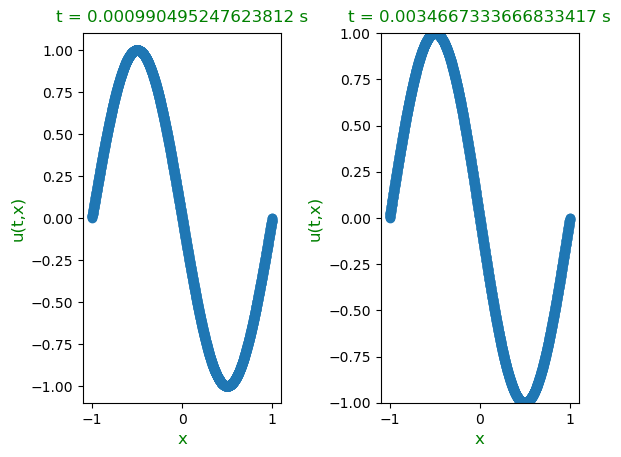

In [10]:
graph()

The data can be loaded, if desired:

In [11]:
vx = np.loadtxt('burgers_solution_x.csv', delimiter=",")
vt = np.loadtxt('burgers_solution_t.csv', delimiter=",")
vu = np.loadtxt('burgers_solution_u.csv', delimiter=",")

In [47]:
vx.shape, vt.shape, vu.shape

((2000,), (2000,), (2000, 2000))

In [13]:
import scipy.io
data = scipy.io.loadmat('burgers_shock.mat')

In [17]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

In [31]:
data['usol'].shape

(256, 100)

In [29]:
X.flatten()[:, None].shape

(25600, 1)

In [24]:
X_star.shape

(25600, 2)

In [25]:
u_star.shape

(25600, 1)

In [26]:
idx = np.random.choice(X_star.shape[0], 2000, replace=False)

In [27]:
idx.shape

(2000,)